In [1]:
from lusidtools.jupyter_tools import toggle_code

"""Complex Look-through Valuation with Multiple Levels

The following notebook details how to compute PVs across different levels of look-through for 
both securitised funds and Index Futures 

Attributes
----------
valuation
transactions
instruments
recipes
futures
securitised portfolios
"""

toggle_code("Hide docstring")

# Look-through Valuation and Reporting


## Table of contents

- 1. [Overview](#1.-Overview)
- 2. [Setup](#2.-Setup)
- 3. [Load Data](#3.-Load-Data)
   * [3.1 Portfolios](#3.1-Portfolios)
   * [3.2 Instruments](#3.2-Instruments)
   * [3.3 Transactions](#3.4-Transactions)   
   * [3.4 Quotes](#3.5-Quotes)
- 4. [Get Holdings](#4.Get-Holdings)
   * [4.1 Get Holdings with Instruments as Securitized Portfolios](#4.1-Get-Holdings-with-Instruments-as-Securitized-Portfolios)
- 5. [Run Valuations](#5.-Run-Valuations)
    * [5.1 Create Recipes](#5.1-Create-Recipes)
    * [5.2 Create Valuation Function](#5.2-Create-Valuation-Function)
    * [5.3 Top Level Valuation](#5.3-Top-Level-Valuation)
    * [5.4 Fund Look-through Valuation](#5.4-Fund-Look-through-Valuation)

# 1. Overview

In this Notebook, we present some of the look-through valuation capabilities available in LUSID across a multi-level security and fund structure. We look at these in the context of several securitised portfolio. 

Our securitised portfolio hiearchy is constructed of three levels, including 
- 'Cyan Valley Asset Management' as portfolio group at the top level
- Three portfolios in "Investment Plan" level, which are all added to 'Cyan Valley Asset Management' portfolio group
- Three portfolios in "Asset Class" level

There are also nine portfolios in "Portfolios" level, which are responsible for trading listed instruments.

The fund structure, and the portion of funds which would be allocated to each securitised portfolios are shown in the diagram below. For example, "Stable" Investment Plan portfolio would have 70% of its funds allocated to "Fixed Income" Asset Class portfolio, and 30% to "Equities" Asset Class portfolio.

In the proceeding sections of this Notebook, we'll load all of the requisite data required to model these holdings while performing valuations for January 7th, 2022. 

Importantly, we'll walk through how we can drill down to the underlying positions and holdings in order to give us a clear view of our exposures. 

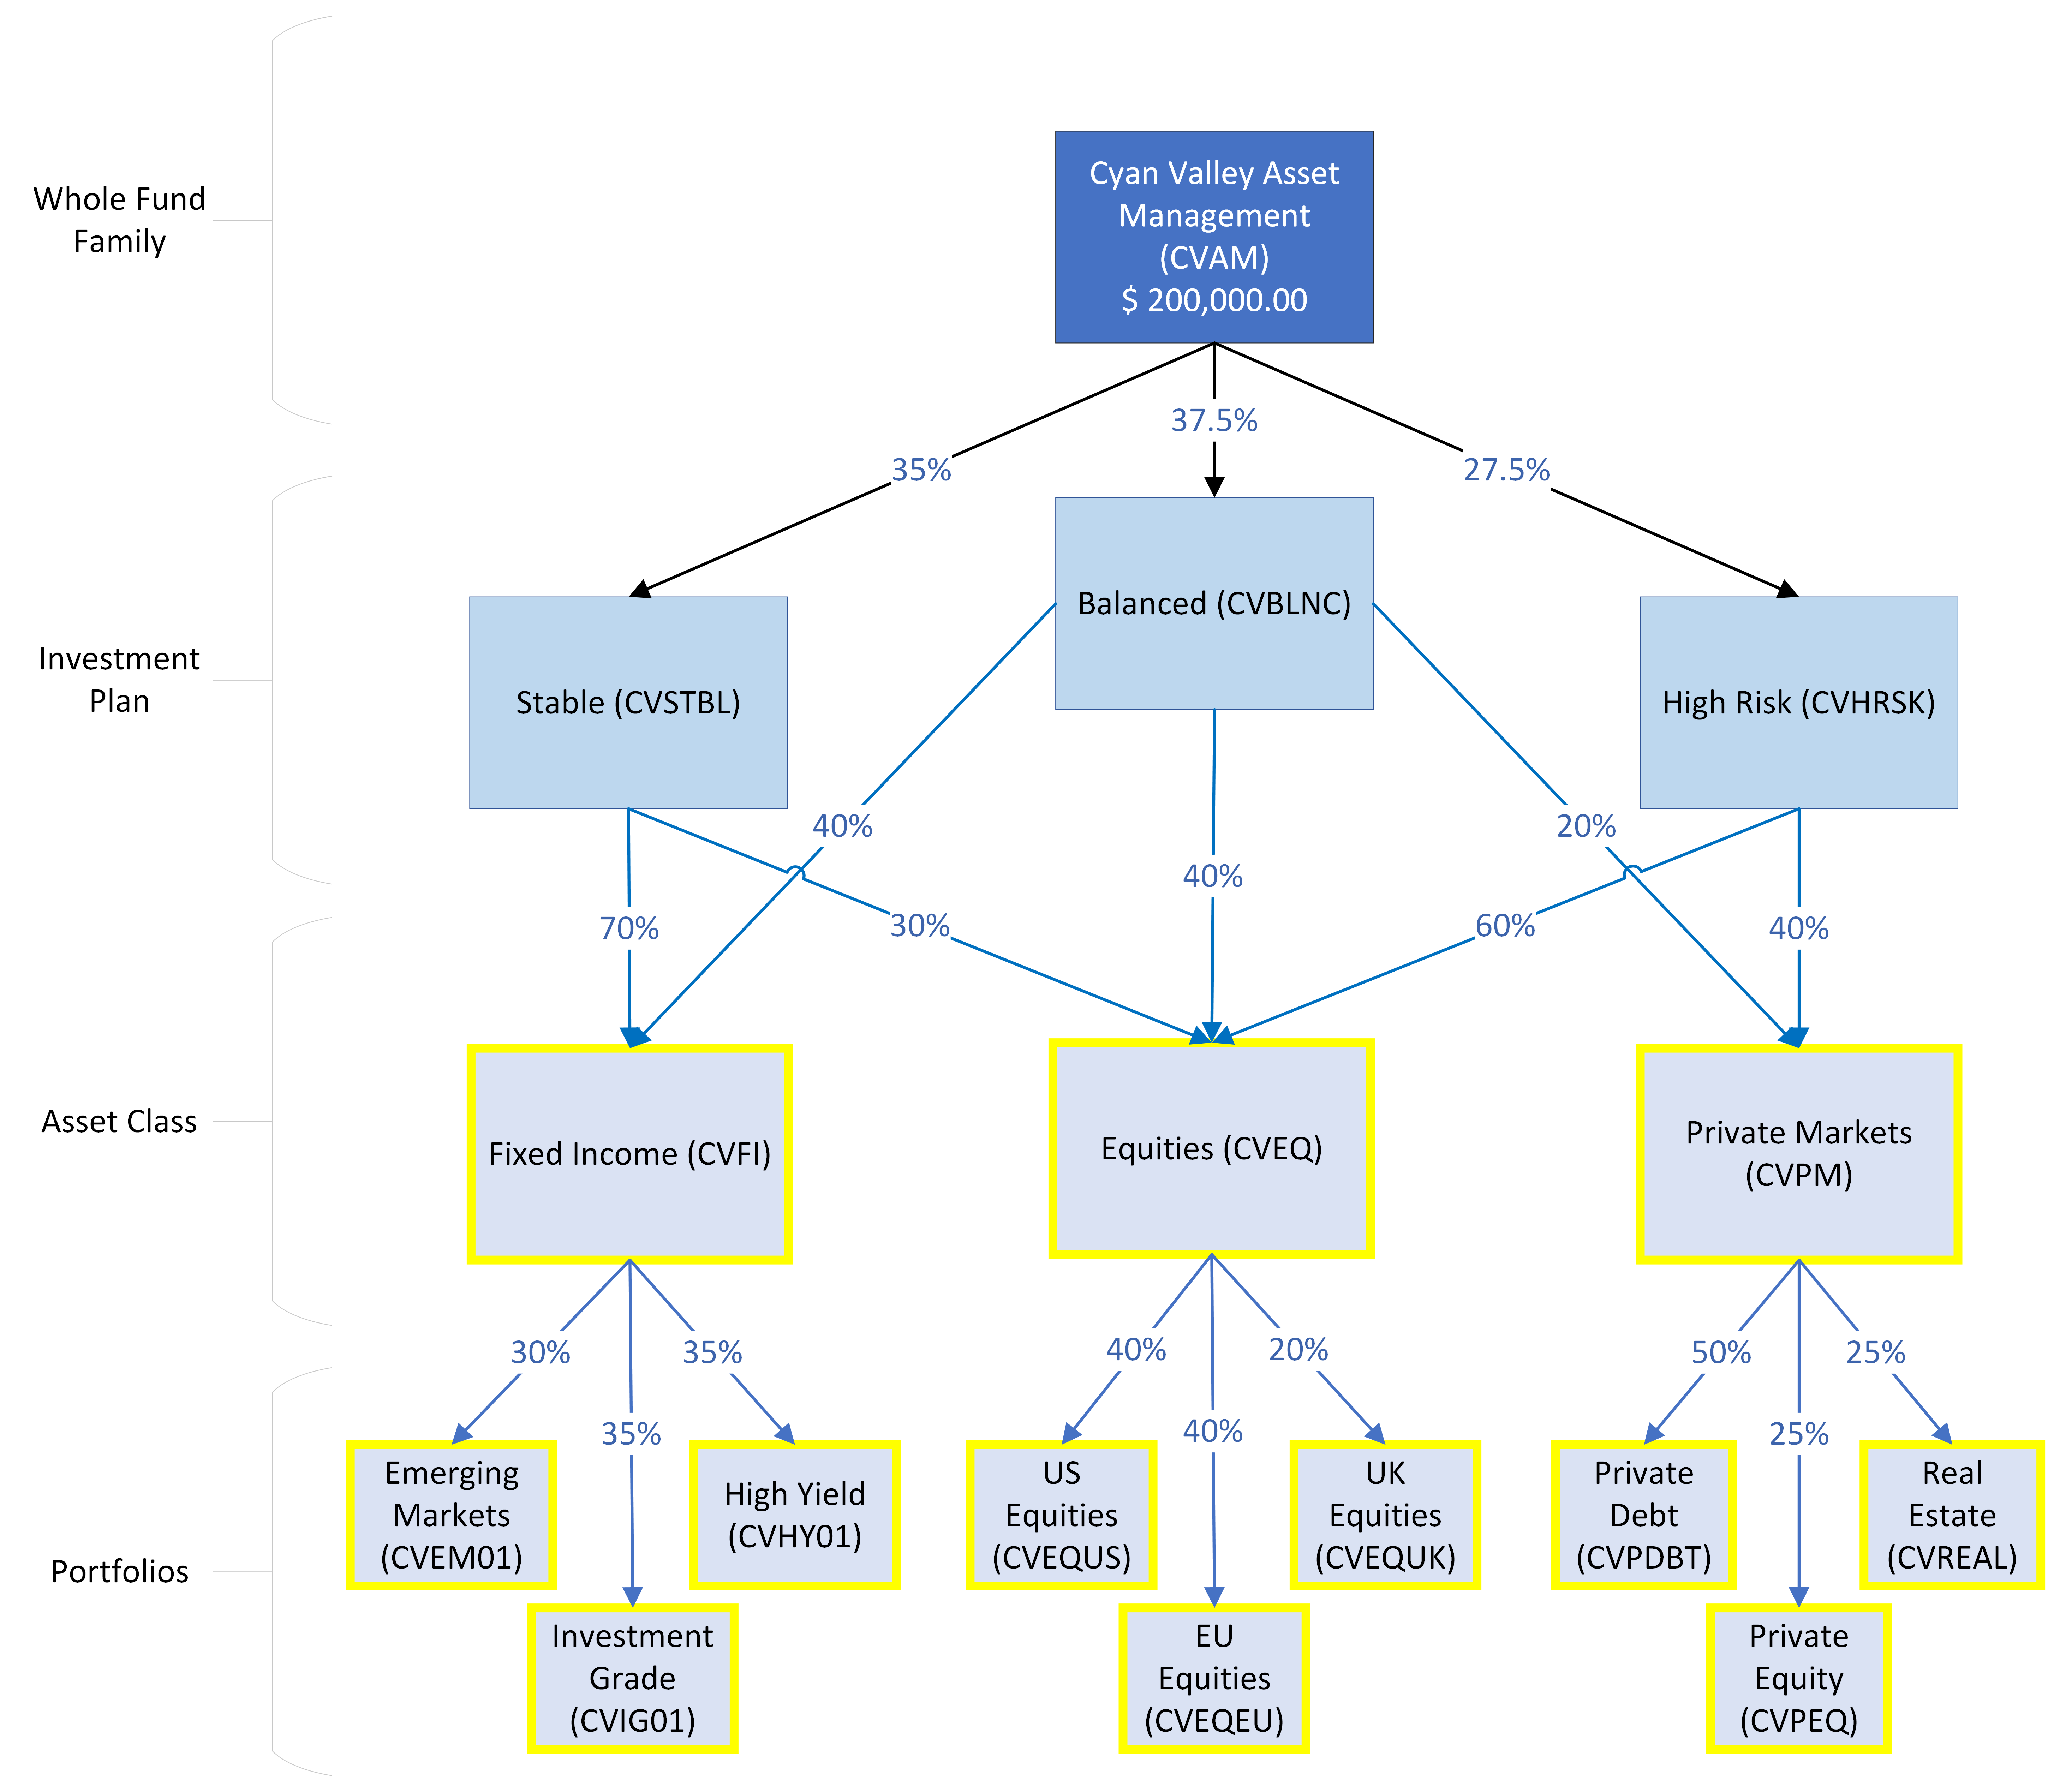

## 2. Setup

We first initialize our various Python libraries, objects, and datasets required to construct our examples:

In [2]:
# Import lusid specific packages
# These are the core lusid packages for interacting with the API via Python
import lusid
import lusid.models as models
import json
import pytz
import uuid
from datetime import datetime
from lusid.utilities import ApiClientFactory
from lusidjam.refreshing_token import RefreshingToken
from lusidtools.pandas_utils.lusid_pandas import lusid_response_to_data_frame
from flatten_json import flatten

import os
import pandas as pd
import math
from itertools import groupby
from IPython.core.display import HTML

# Set pandas dataframe display formatting
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

# Authenticate our user and create our API client
secrets_path = os.getenv("FBN_SECRETS_PATH")

# Initiate an API Factory which is the client side object for interacting with LUSID APIs
api_factory = lusid.utilities.ApiClientFactory(
    token=RefreshingToken(),
    api_secrets_filename = secrets_path,
    app_name="LusidJupyterNotebook")

# Get API URL for easy access in WebUI
api_url = api_factory.api_client.configuration._base_path.replace("api","")

# Load LUSID API Components
portfolio_api = api_factory.build(lusid.api.PortfoliosApi)
properties_api = api_factory.build(lusid.api.PropertyDefinitionsApi)
transaction_portfolio_api = api_factory.build(lusid.api.TransactionPortfoliosApi)
reference_portfolio_api = api_factory.build(lusid.api.ReferencePortfolioApi)
instruments_api = api_factory.build(lusid.api.InstrumentsApi)
quotes_api = api_factory.build(lusid.api.QuotesApi)
configuration_recipe_api = api_factory.build(lusid.api.ConfigurationRecipeApi)
system_configuration_api = api_factory.build(lusid.api.SystemConfigurationApi)
aggregration_api = api_factory.build(lusid.api.AggregationApi)

# Set Global Scope
global_scope = "ibor-fund-of-funds"

# Transaction Portfolios
portfolios_data = pd.read_excel("data/lookthrough_data_complex.xlsx", sheet_name="portfolios")

# Load Requisite Data
weights_investment_plan_data = pd.read_excel("data/lookthrough_data_complex.xlsx", sheet_name="weights_investment_plan")
weights_asset_class_data = pd.read_excel("data/lookthrough_data_complex.xlsx", sheet_name="weights_asset_class")
transaction_data = pd.read_excel("data/lookthrough_data_complex.xlsx", sheet_name="transactions")
price_data = pd.read_excel("data/lookthrough_data_complex.xlsx", sheet_name="market_prices")
instrument_data = pd.read_excel("data/lookthrough_data_complex.xlsx", sheet_name="instruments")

This section of code loads default mappings for certain API responses, so they can be presented in data frame in a readable format.

In [3]:
with open(r"config/get_holdings_mapping.json") as mappings_file:
    get_holdings_json_mapping = json.load(mappings_file)

## 3. Load Data

The majority of our data will be loaded from 'lookthrough_data_complex_new.xlsx'. This includes our portfolios, portfolio group, transactions, instruments, and market quotes.

### 3.1 Portfolios 

We first start by constructing our portfolios. This includes: 

1. Top level "Cyan Valley Asset Management" Portfolio
2. Three "Investment Plans" level Portfolios
3. Three "Asset Class" level Portfolios
4. Nine portfolio, of which we will book transactions for trading listed instruments to

In [4]:
portfolios_data

,portfolio_code,name,portfolio_type,portfolio_level
0,CVAM,Cyan Valley Asset Management,Transaction,WholeFundFamily
1,CVSTBL,Stable Investment Plan,Transaction,InvestmentPlan
2,CVBLNC,Balanced Investment Plan,Transaction,InvestmentPlan
3,CVHRSK,High Risk Plan,Transaction,InvestmentPlan
4,CVFI,Fixed Income,Transaction,AssetClass
5,CVEQ,Equities,Transaction,AssetClass
6,CVPM,Private Markets,Transaction,AssetClass
7,CVEM01,Emerging Markets,Transaction,Portfolio
8,CVIG01,Investment Grade,Transaction,Portfolio
9,CVHY01,High Yield,Transaction,Portfolio


In [5]:
# Create our Transaction Portfolios
def load_txn_portfolio(portfolio_code, portfolio_name):
    try:
        transaction_portfolio_api.create_portfolio(
            scope=global_scope,
            create_transaction_portfolio_request=models.CreateTransactionPortfolioRequest(
                display_name=portfolio_name,
                code=portfolio_code,
                base_currency="USD",
                created="2022-01-01",
                instrument_scopes=[global_scope]
            ),
        )
        print("Portfolio: " + portfolio_code + " loaded!")

    except lusid.ApiException as e:
        print(json.loads(e.body)["title"])
        
for index, row in portfolios_data.iterrows():
    if (row["portfolio_type"] == "Transaction"):
        load_txn_portfolio(row["portfolio_code"], row["name"])
    else:
        print("Portfolio: " + row["portfolio_code"] + " not loaded, because it is " + row["portfolio_type"])

Portfolio: CVAM loaded!
Portfolio: CVSTBL loaded!
Portfolio: CVBLNC loaded!
Portfolio: CVHRSK loaded!
Portfolio: CVFI loaded!
Portfolio: CVEQ loaded!
Portfolio: CVPM loaded!
Portfolio: CVEM01 loaded!
Portfolio: CVIG01 loaded!
Portfolio: CVHY01 loaded!
Portfolio: CVEQUS loaded!
Portfolio: CVEQEU loaded!
Portfolio: CVEQUK loaded!
Portfolio: CVPDBT loaded!
Portfolio: CVPEQ loaded!
Portfolio: CVREAL loaded!


### 3.2 Instruments

Next, we create the instruments which will be traded through our portfolios

#### 3.2.1 Instrument Properties
Before creating any instruments, we first create some instrument properties, which will be used for valuation aggregation later.

In [6]:
properties = [
    ("Sector", "string"),
    ("Industry", "string"),
    ("Region", "string") 
]

for property_code, dtype in properties:
    try:
        properties_api.create_property_definition(
            create_property_definition_request=models.CreatePropertyDefinitionRequest(
                domain="Instrument",
                scope=global_scope,
                code=property_code,
                display_name=property_code,
                data_type_id=models.ResourceId(code=dtype, scope="system"),
            )
        )
    except lusid.ApiException as e:
        print(json.loads(e.body)["title"])

Error creating Property Definition 'Instrument/ibor-fund-of-funds/Sector' because it already exists.
Error creating Property Definition 'Instrument/ibor-fund-of-funds/Industry' because it already exists.
Error creating Property Definition 'Instrument/ibor-fund-of-funds/Region' because it already exists.


#### 3.2.2 Create a Lookthrough Instrument for Funds as Securitised Transaction Portfolios
Key to our `SimpleInstrument` construction is the field `look_through_portfolio_id`. 

For each portfolio which would need to be securitised, we will create an instrument for it. In the instruments data set, they would have instrument_type as "lookthrough_instrument".

In [7]:
for index, row in instrument_data.iterrows():

    if isinstance(row["lookthrough_id"], float):
        continue
        
    simple_instrument = models.SimpleInstrument(
        instrument_type="SimpleInstrument",
        dom_ccy=row["currency"],
        asset_class="Equities",
        simple_instrument_type="Fund"
    )

    client_internal=row["client_internal"]
    
    response = instruments_api.upsert_instruments(
        scope=global_scope,
        request_body={
            client_internal: models.InstrumentDefinition(
                name=row["name"],
                definition=simple_instrument,
                identifiers={
                    "ClientInternal": models.InstrumentIdValue(value=row["client_internal"])
                },
                look_through_portfolio_id=models.ResourceId(
                    scope=global_scope, code=row["lookthrough_id"]
                ),
                properties=[
                    models.ModelProperty(
                        key=f"Instrument/{global_scope}/Sector",
                        value=models.PropertyValue(label_value=row['sector']),
                    ),
                    models.ModelProperty(
                        key=f"Instrument/{global_scope}/Industry",
                        value=models.PropertyValue(label_value=row['industry']),
                    ),
                    models.ModelProperty(
                        key=f"Instrument/{global_scope}/Region",
                        value=models.PropertyValue(label_value=row['region']),
                    ),
                ],     
            )
        }
    )
    
    display ("Upserted instrument " + row["client_internal"] + "! LUID: " + response.values[client_internal].lusid_instrument_id)
    
print ("Securitised Funds Upserted!")   

'Upserted instrument fund_CVSTBL! LUID: LUID_00003DB9'

'Upserted instrument fund_CVBLNC! LUID: LUID_00003DBA'

'Upserted instrument fund_CVHRSK! LUID: LUID_00003DBB'

'Upserted instrument fund_CVEM01! LUID: LUID_00003D9G'

'Upserted instrument fund_CVEQ! LUID: LUID_00003D9H'

'Upserted instrument fund_CVEQEU! LUID: LUID_00003D9I'

'Upserted instrument fund_CVEQUK! LUID: LUID_00003D9J'

'Upserted instrument fund_CVEQUS! LUID: LUID_00003D9K'

'Upserted instrument fund_CVFI! LUID: LUID_00003D9L'

'Upserted instrument fund_CVHY01! LUID: LUID_00003D9M'

'Upserted instrument fund_CVIG01! LUID: LUID_00003D9N'

'Upserted instrument fund_CVPDBT! LUID: LUID_00003D9O'

'Upserted instrument fund_CVPEQ! LUID: LUID_00003D9P'

'Upserted instrument fund_CVPM! LUID: LUID_00003D9Q'

'Upserted instrument fund_CVREAL! LUID: LUID_00003D9R'

Securitised Funds Upserted!


#### 3.2.3 Equities
Next, we load our publicly listed equity instruments as type 'Equity'.

In [8]:
def load_equity(data):
          
    if (row["instrument_type"] != "equity"):
        return
        
    client_internal = data["client_internal"]
    
    equity = models.Equity(
        instrument_type="Equity",
        dom_ccy=data["currency"],
    )

    equity_definition = models.InstrumentDefinition(
        name=data["name"],
        identifiers={"ClientInternal": models.InstrumentIdValue(data["client_internal"]),
                     "Ticker": models.InstrumentIdValue(data["ticker"])
                    },
        definition=equity,
        properties=[
                models.ModelProperty(
                key=f"Instrument/{global_scope}/Sector",
                value=models.PropertyValue(label_value=row['sector']),
            ),
                models.ModelProperty(
                key=f"Instrument/{global_scope}/Industry",
                value=models.PropertyValue(label_value=row['industry']),
            ),
                models.ModelProperty(
                key=f"Instrument/{global_scope}/Region",
                value=models.PropertyValue(label_value=row['region']),
            ),
        ],        
    )

    # upsert the instrument
    upsert_request = {client_internal: equity_definition}
    upsert_response = instruments_api.upsert_instruments(scope=global_scope, request_body=upsert_request)
    equity_luid = upsert_response.values[client_internal].lusid_instrument_id
    display ("Upserted instrument " + data["client_internal"] + "! LUID: " + equity_luid)

for index, row in instrument_data.iterrows():
    
    if not isinstance(row["lookthrough_id"], float):
        continue
        
    load_equity(row)

print ("Instruments Upserted!")

'Upserted instrument eq_ca_RY! LUID: LUID_00003D9S'

'Upserted instrument eq_ca_SU! LUID: LUID_00003D9T'

'Upserted instrument eq_uk_BCS! LUID: LUID_00003D9U'

'Upserted instrument eq_uk_BP! LUID: LUID_00003D9V'

'Upserted instrument eq_us_AAPL! LUID: LUID_00003D9W'

'Upserted instrument eq_eu_AIR! LUID: LUID_00003D9X'

'Upserted instrument eq_us_AMZN! LUID: LUID_00003D9Y'

'Upserted instrument eq_uk_AZN! LUID: LUID_00003D9Z'

'Upserted instrument eq_us_BABA! LUID: LUID_00003DA0'

'Upserted instrument eq_us_BIDU! LUID: LUID_00003DA1'

'Upserted instrument eq_us_BLK! LUID: LUID_00003DA2'

'Upserted instrument eq_us_C! LUID: LUID_00003DA3'

'Upserted instrument eq_us_CVX! LUID: LUID_00003DA4'

'Upserted instrument eq_us_FB! LUID: LUID_00003DA5'

'Upserted instrument eq_us_GOOGL! LUID: LUID_00003DA6'

'Upserted instrument eq_us_GS! LUID: LUID_00003DA7'

'Upserted instrument eq_uk_GSK! LUID: LUID_00003DA8'

'Upserted instrument eq_uk_HSBA! LUID: LUID_00003DA9'

'Upserted instrument eq_us_INTC! LUID: LUID_00003DAA'

'Upserted instrument eq_us_JPM! LUID: LUID_00003DAB'

'Upserted instrument eq_eu_LIN! LUID: LUID_00003DAC'

'Upserted instrument eq_uk_LLOY! LUID: LUID_00003DAD'

'Upserted instrument eq_us_MSFT! LUID: LUID_00003DAE'

'Upserted instrument eq_us_NFLX! LUID: LUID_00003DAF'

'Upserted instrument eq_us_NVDA! LUID: LUID_00003DAG'

'Upserted instrument eq_us_ORCL! LUID: LUID_00003DAH'

'Upserted instrument eq_eu_SAN! LUID: LUID_00003DAI'

'Upserted instrument eq_eu_SAP! LUID: LUID_00003DAJ'

'Upserted instrument eq_us_TSLA! LUID: LUID_00003DAK'

'Upserted instrument eq_us_UBER! LUID: LUID_00003DAL'

'Upserted instrument eq_eu_VOW3! LUID: LUID_00003DAM'

'Upserted instrument eq_us_XOM! LUID: LUID_00003DAN'

'Upserted instrument eq_uk_TSCO! LUID: LUID_00003DAO'

Instruments Upserted!


#### 3.2.3 Bonds
Next, we load our bonds as `SimpleInstrument`.

In [9]:
def load_bond(data):
    if (row["instrument_type"] != "bond"):
        return

    client_internal = "Instrument/default/ClientInternal"

    bond_definition = models.SimpleInstrument(
        instrument_type="SimpleInstrument",
        dom_ccy=data["currency"],
        maturity_date="2030-01-15T00:00:00Z",
        simple_instrument_type="Bond",
        asset_class="InterestRates"
    )

    bond = models.InstrumentDefinition(
        name=data["name"],
        identifiers={
            "ClientInternal": models.InstrumentIdValue(data["client_internal"])        
        },
        definition=bond_definition,
        properties=[
                models.ModelProperty(
                key=f"Instrument/{global_scope}/Sector",
                value=models.PropertyValue(label_value=row['sector']),
            ),
                models.ModelProperty(
                key=f"Instrument/{global_scope}/Industry",
                value=models.PropertyValue(label_value=row['industry']),
            ),
                models.ModelProperty(
                key=f"Instrument/{global_scope}/Region",
                value=models.PropertyValue(label_value=row['region']),
            ),
        ],        
    )

    # upsert the instrument
    upsert_request = {client_internal: bond}
    upsert_response = instruments_api.upsert_instruments(scope=global_scope, request_body=upsert_request)
    equity_luid = upsert_response.values[client_internal].lusid_instrument_id
    display ("Upserted instrument " + data["client_internal"] + "! LUID: " + equity_luid)

for index, row in instrument_data.iterrows():
    
    if not isinstance(row["lookthrough_id"], float):
        continue
        
    load_bond(row)

print ("Instruments Upserted!")

'Upserted instrument MXGOVBND! LUID: LUID_00003DAP'

'Upserted instrument BRZCORPBND! LUID: LUID_00003DAQ'

'Upserted instrument TURGOVBND! LUID: LUID_00003DAR'

'Upserted instrument IDNCORPBND! LUID: LUID_00003DAS'

'Upserted instrument CETERA 7.5 04/01/29 144A! LUID: LUID_00003DAT'

'Upserted instrument NOVHOL 8.75 04/15/30 144A! LUID: LUID_00003DAU'

'Upserted instrument HOWDEN 11 10/01/27 144A! LUID: LUID_00003DAV'

'Upserted instrument ROCSOF 6.5 02/15/29 144A! LUID: LUID_00003DAW'

'Upserted instrument MMM 2.65 04/15/25! LUID: LUID_00003DAX'

'Upserted instrument AFL 6.9 12/17/39! LUID: LUID_00003DAY'

'Upserted instrument LM 5.625 01/15/44! LUID: LUID_00003DAZ'

'Upserted instrument COMM 6 06/15/25 144A! LUID: LUID_00003DB0'

'Upserted instrument AECI_LTD_5.5! LUID: LUID_00003DB1'

'Upserted instrument Finbourne_SAFE! LUID: LUID_00003DB2'

'Upserted instrument Morrisons! LUID: LUID_00003DB3'

'Upserted instrument SYD241232! LUID: LUID_00003DB4'

'Upserted instrument LON343239! LUID: LUID_00003DB5'

'Upserted instrument Morrisons_4_05/01/2025_Private! LUID: LUID_00003DB6'

'Upserted instrument HSBC_0.10_05/01/2023! LUID: LUID_00003DB7'

'Upserted instrument BNP_0.08_05/07/2022! LUID: LUID_00003DB8'

Instruments Upserted!


### 3.3 Transactions

#### 3.3.1 Transactions to trade listed instruments 
First we insert transactions which are two trading instruments and put funds into portfolios.

In [10]:
transaction_data

,txn_id,txn_date,txn_type,trade_date,settle_date,portfolio_code,Unnamed: 6,quantity,client_internal,cash_id,currency,txn_price,total_consideration
0,txnid_0001,2022-01-05T00:00:00Z,FundsIn,2022-01-05T08:00:00Z,2022-01-05T08:00:00Z,CVAM,NaN,200000,NaN,USD,USD,1.00,"200,000.00"
1,txnid_0004,2022-01-05T00:00:00Z,Buy,2022-01-05T08:00:00Z,2022-01-05T08:00:00Z,CVEQUS,NaN,50,eq_us_AAPL,NaN,USD,125.00,"6,250.00"
2,txnid_0005,2022-01-05T00:00:00Z,Buy,2022-01-05T08:00:00Z,2022-01-05T08:00:00Z,CVEQUS,NaN,30,eq_us_MSFT,NaN,USD,225.00,"6,750.00"
3,txnid_0006,2022-01-05T00:00:00Z,Buy,2022-01-05T08:00:00Z,2022-01-05T08:00:00Z,CVEQUS,NaN,10,eq_us_AMZN,NaN,USD,"3,200.00","32,000.00"
4,txnid_0007,2022-01-05T00:00:00Z,Buy,2022-01-05T08:00:00Z,2022-01-05T08:00:00Z,CVEQUS,NaN,20,eq_us_GOOGL,NaN,USD,"2,100.00","42,000.00"
5,txnid_0008,2022-01-05T00:00:00Z,Buy,2022-01-05T08:00:00Z,2022-01-05T08:00:00Z,CVEQUS,NaN,40,eq_us_FB,NaN,USD,300.00,"12,000.00"
6,txnid_0009,2022-01-05T00:00:00Z,Buy,2022-01-05T08:00:00Z,2022-01-05T08:00:00Z,CVEQUK,NaN,500,eq_uk_BP,NaN,GBP,5.00,"2,500.00"
7,txnid_0010,2022-01-05T00:00:00Z,Buy,2022-01-05T08:00:00Z,2022-01-05T08:00:00Z,CVEQUK,NaN,200,eq_uk_HSBA,NaN,GBP,4.00,800.00
8,txnid_0011,2022-01-05T00:00:00Z,Buy,2022-01-05T08:00:00Z,2022-01-05T08:00:00Z,CVEQUK,NaN,1000,eq_uk_LLOY,NaN,GBP,2.50,"2,500.00"
9,txnid_0012,2022-01-05T00:00:00Z,Buy,2022-01-05T08:00:00Z,2022-01-05T08:00:00Z,CVEQUK,NaN,30,eq_uk_AZN,NaN,GBP,80.00,"2,400.00"


In [11]:
# Load Transactions
for index, row in transaction_data.iterrows():
    
    if isinstance(row["client_internal"], float):
        primary_instrument_identifier = { "Instrument/default/Currency": row["cash_id"] }
    else:
        primary_instrument_identifier = { "Instrument/default/ClientInternal": row["client_internal"] }

    upsert_transactions = transaction_portfolio_api.upsert_transactions(
        scope=global_scope,
        code=row['portfolio_code'],
        transaction_request=[
            models.TransactionRequest(
                transaction_id=row["txn_id"],
                type=row["txn_type"],
                instrument_identifiers=primary_instrument_identifier,
                transaction_date=row["trade_date"],
                settlement_date=row["settle_date"],
                units=row["quantity"],
                transaction_price=models.TransactionPrice(
                    price=row["txn_price"], type="Price"
                ),
                total_consideration=models.CurrencyAndAmount(
                    amount=row["total_consideration"], currency=row["currency"]
                ),
            )
        ],
    )

#### 3.3.1 Transactions to "trade" securitised portfolios
Then, we are inserting transactions to indicate funds are being allocated to each of its associated portfolios. 

We will do this first for "Investment Plan" level portfolios first, then "Asset Class" level portfolios.

The below function performs the following: 

1. Group weightings by `parent_portfolio_code`
2. For each grouping, calculate the allocated cost to each of its "child" portfolio. This is 
    `"Total funds of parent portfolio" * "weight allocated to child portfolio`
3. Buy the securitised instrument associated to the child portfolio, with the amount calculated at step 2
4. Put amount of funds in to the child portfolio calculated at step 2

In [12]:
for parent_portfolio_code, portfolio_weightings in weights_investment_plan_data.groupby(by=["parent_portfolio_code"]):
    holdings_of_parent_portfolio = transaction_portfolio_api.get_holdings(
        scope=global_scope,
        code=parent_portfolio_code,
        filter="instrumentUid eq 'CCY_USD'");
    
    for index2, row in portfolio_weightings.iterrows():

        securitized_instrument_identifier = { "Instrument/default/ClientInternal": "fund_" + row["child_portfolio_code"] }
        cost_to_buy_securitized_instrument = holdings_of_parent_portfolio.values[0].cost.amount * row["weight"]

        buy_securitized_instrument_txn = transaction_portfolio_api.upsert_transactions(
            scope=global_scope,
            code=parent_portfolio_code,
            transaction_request=[
                models.TransactionRequest(
                    transaction_id=row["txn_id"],
                    type="Buy",
                    instrument_identifiers=securitized_instrument_identifier,
                    transaction_date=row["trade_date"],
                    settlement_date=row["settle_date"],
                    units=cost_to_buy_securitized_instrument,
                    transaction_price=models.TransactionPrice(
                        price=1, type="Price"
                    ),
                    total_consideration=models.CurrencyAndAmount(
                        amount=cost_to_buy_securitized_instrument, currency=row["currency"]
                    ),
                )
            ],
        )

        funds_in_identifier = { "Instrument/default/Currency": row["currency"] }

        funds_in_child_portfolio_txn = transaction_portfolio_api.upsert_transactions(
            scope=global_scope,
            code=row['child_portfolio_code'],
            transaction_request=[
                models.TransactionRequest(
                    transaction_id=row["txn_id"],
                    type="FundsIn",
                    instrument_identifiers=funds_in_identifier,
                    transaction_date=row["trade_date"],
                    settlement_date=row["settle_date"],
                    units=cost_to_buy_securitized_instrument,
                    transaction_price=models.TransactionPrice(
                        price=1, type="Price"
                    ),
                    total_consideration=models.CurrencyAndAmount(
                        amount=cost_to_buy_securitized_instrument, currency=row["currency"]
                    ),
                )
            ],
        )
        

In [13]:
for parent_portfolio_code, portfolio_weightings in weights_asset_class_data.groupby(by=["parent_portfolio_code"]):

    holdings_of_parent_portfolio = transaction_portfolio_api.get_holdings(
        scope=global_scope,
        code=parent_portfolio_code,
        filter="instrumentUid eq 'CCY_USD'");
    
    for index2, row in portfolio_weightings.iterrows():

        securitized_instrument_identifier = { "Instrument/default/ClientInternal": "fund_" + row["child_portfolio_code"] }
        cost_to_buy_securitized_instrument = holdings_of_parent_portfolio.values[0].cost.amount * row["weight"]

        buy_securitized_instrument_txn = transaction_portfolio_api.upsert_transactions(
            scope=global_scope,
            code=parent_portfolio_code,
            transaction_request=[
                models.TransactionRequest(
                    transaction_id=row["txn_id"],
                    type="Buy",
                    instrument_identifiers=securitized_instrument_identifier,
                    transaction_date=row["trade_date"],
                    settlement_date=row["settle_date"],
                    units=cost_to_buy_securitized_instrument,
                    transaction_price=models.TransactionPrice(
                        price=1, type="Price"
                    ),
                    total_consideration=models.CurrencyAndAmount(
                        amount=cost_to_buy_securitized_instrument, currency=row["currency"]
                    ),
                )
            ],
        )

        funds_in_identifier = { "Instrument/default/Currency": row["currency"] }

        funds_in_child_portfolio_txn = transaction_portfolio_api.upsert_transactions(
            scope=global_scope,
            code=row['child_portfolio_code'],
            transaction_request=[
                models.TransactionRequest(
                    transaction_id=row["txn_id"],
                    type="FundsIn",
                    instrument_identifiers=funds_in_identifier,
                    transaction_date=row["trade_date"],
                    settlement_date=row["settle_date"],
                    units=cost_to_buy_securitized_instrument,
                    transaction_price=models.TransactionPrice(
                        price=1, type="Price"
                    ),
                    total_consideration=models.CurrencyAndAmount(
                        amount=cost_to_buy_securitized_instrument, currency=row["currency"]
                    ),
                )
            ],
        )

### 3.4 Quotes
We now load in the relavent market prices for our valuation date of Jan 7th, 2022

In [14]:
# Display Instrument Prices
price_data

,date,id,id_type,price,currency
0,2022-01-07T00:00:00Z,AFL 6.9 12/17/39,ClientInternal,110.57,USD
1,2022-01-07T00:00:00Z,BRZCORPBND,ClientInternal,88.21,USD
2,2022-01-07T00:00:00Z,CETERA 7.5 04/01/29 144A,ClientInternal,79.20,USD
3,2022-01-07T00:00:00Z,COMM 6 06/15/25 144A,ClientInternal,95.50,USD
4,2022-01-07T00:00:00Z,eq_ca_RY,ClientInternal,137.00,CAD
...,...,...,...,...,...
81,2022-01-07T00:00:00Z,SYD241232,ClientInternal,103.00,USD
82,2022-01-07T00:00:00Z,LON343239,ClientInternal,88.99,GBP
83,2022-01-07T00:00:00Z,Morrisons_4_05/01/2025_Private,ClientInternal,12.40,GBP
84,2022-01-07T00:00:00Z,HSBC_0.10_05/01/2023,ClientInternal,23.95,GBP


In [15]:
instrument_quotes = {
    str(uuid.uuid4()): models.UpsertQuoteRequest(
            quote_id=models.QuoteId(
                quote_series_id=models.QuoteSeriesId(
                    provider="Lusid",
                    instrument_id=price["id"],
                    instrument_id_type=price["id_type"],
                    quote_type="Price",
                    field="mid",
                ),
                effective_at=price["date"],
            ),
            metric_value=models.MetricValue(value=price["price"], unit=price["currency"]),        
    )
    for row, price in price_data.iterrows()
}

# Upsert the quotes into LUSID
response = quotes_api.upsert_quotes(
    scope=global_scope, request_body=instrument_quotes
)

## 4. Get Holdings

With all transactions in place, we can first get holdings for various portolios and examine how they are presented.

### 4.1 Get Holdings with Instruments as Securitized Portfolios

First, let's examine holdings for top level portfolio "CVAM".

You will see three holdings returned; each holding references a LusidInstrumentId, which are the securitized funds representing its associated portfolio.

Click link below to view how it is presented on LUSID Website. The `Lookthrough Portfolio` column should assist to "drill through" the portfolios. 

In [16]:
display(HTML(f'<a href="{api_url}app/dashboard/holdings?scope=ibor-fund-of-funds&code=CVAM&entityType=Portfolio&effectiveDate=2022-01-07T00:00:00.000Z" target="_blank">See holdings for Portfolio CVAM in LUSID</a>'))

In [17]:
get_holdings_response = transaction_portfolio_api.get_holdings(
    scope=global_scope,
    code='CVAM');

holdings_df = lusid_response_to_data_frame(
    get_holdings_response.values,
    rename_properties=True,
    column_name_mapping=get_holdings_json_mapping,
)

display(holdings_df)

,instrument_scope,LusidInstrumentId,SubHoldingKeys,SourcePortfolioId,SourcePortfolioScope(default-Properties),HoldingType,Units,SettledUnits,Amount-Cost,Currency-Cost,Amount-CostPortfolioCcy,Currenct-CostPortfolioCcy,currency,holding_type_name
0,ibor-fund-of-funds,LUID_00003DB9,{},CVAM,ibor-fund-of-funds,P,"70,000.00","70,000.00","70,000.00",USD,"70,000.00",USD,USD,Position
1,ibor-fund-of-funds,LUID_00003DBA,{},CVAM,ibor-fund-of-funds,P,"75,000.00","75,000.00","75,000.00",USD,"75,000.00",USD,USD,Position
2,ibor-fund-of-funds,LUID_00003DBB,{},CVAM,ibor-fund-of-funds,P,"55,000.00","55,000.00","55,000.00",USD,"55,000.00",USD,USD,Position
3,default,CCY_USD,{},CVAM,ibor-fund-of-funds,B,-0.00,-0.00,0.00,USD,0.00,USD,USD,Balance


## 5. Run Valuations

Now that the requisite data is in place to model our portfolios and holdings, we want to start running valuations. In order to do this, we'll create three recipes:

- `DirectHoldingsValuationRecipe` - The top level valuation recipe which will value all directly held positions with no look-through
- `FundLookthroughValuationRecipe` - The fund level valuation recipe will look through all securitised portfolios.

Importantly, we have two model rules that control look-through for `SimpleInstrument` and `Equity` instrument types. 

For `FundLookthroughValuationRecipe`, the model rule specifies the use of an `InlinedIndex` model that expands each `SimpleInstrument` into it's underlying holdings. Specifying the `IndexModelOptions` under the `model_options` field then tells LUSID how to scale the underlying portfolio PVs.

Note that our recipe below depends on two types of LUSID licenses. First, we need a license for each instrument type we're working with: `Equity`, `SimpleInstrument`. Second, we need licenses for the two pricing models we're using: `InlinedIndex` and `SimpleStatic`. For additional details on Recipes, please see the following [KB article](https://support.lusid.com/knowledgebase/article/KA-01895/en-us).

### 5.1 Create Recipes

In [18]:
# Create three recipes for varying levels of look-through
def UpsertRecipe(recipe_code):
    
    model_rules=[]
        
    if recipe_code == "FundLookthroughValuationRecipe":
        model_rules.append(models.VendorModelRule(
            supplier="Lusid",
            model_name="SimpleStatic",
            instrument_type="SimpleInstrument",
            model_options=models.IndexModelOptions(
                portfolio_scaling="Sum",
                model_options_type="IndexModelOptions"),
            )
        )        

    configuration_recipe = models.ConfigurationRecipe(
        scope=global_scope,
        code=recipe_code,
        market=models.MarketContext(
            market_rules=[
                models.MarketDataKeyRule(
                    key="Equity.ClientInternal.*",
                    supplier="Lusid",
                    data_scope=global_scope,
                    quote_type="Price",
                    field="mid",
                    quote_interval="5D",
                )
            ],
            options=models.MarketOptions(
                default_supplier="Lusid",
                default_instrument_code_type="ClientInternal",
                default_scope=global_scope,
                attempt_to_infer_missing_fx=True             
            ),
        ),
        pricing=models.PricingContext(
            model_rules=model_rules
        ),    
    )

    upsert_configuration_recipe_response = (
        configuration_recipe_api.upsert_configuration_recipe(
            upsert_recipe_request=models.UpsertRecipeRequest(
                configuration_recipe=configuration_recipe
            )
        )
    )
    
UpsertRecipe("DirectHoldingsValuationRecipe")
UpsertRecipe("FundLookthroughValuationRecipe")

### 5.2 Create Valuation Function

We'll create a valuation function that allows us to aggregate on an instrument property. In our example, this will either be by industry, sector, or region.

In [19]:
# Create a valuation function allowing users to aggregate based on different instrument properies
# as well as by specifying the look-through recipe
def get_daily_val(date, portfolio_code, aggregate_field, recipe_code):
    
    group_by = []
    metricsList = []
    columnsToRename = {}
    
    if aggregate_field:
        metricsList.extend([
            models.AggregateSpec(f"Instrument/{global_scope}/{aggregate_field}", "Value"),
            models.AggregateSpec(f"Valuation/PvInReportCcy", "Sum"),        
            models.AggregateSpec(f"Valuation/ExposureInReportCcy", "Sum"),             
            models.AggregateSpec(f"Holding/default/Units", "Value"),              
        ])
        group_by.append(f"Instrument/{global_scope}/{aggregate_field}")
        columnsToRename={
            f"Sum(Valuation/PvInReportCcy)": "PV (Reporting Ccy)",
            f"Sum(Valuation/ExposureInReportCcy)": "Exposure (Reporting Ccy)"
        }
        
    else:
        metricsList.extend([
            models.AggregateSpec(f"Instrument/default/Name", "Value"),
            models.AggregateSpec(f"Instrument/{global_scope}/Sector", "Value"), 
            models.AggregateSpec(f"Instrument/{global_scope}/Industry", "Value"),
            models.AggregateSpec(f"Instrument/{global_scope}/Region", "Value"),             
            models.AggregateSpec(f"Valuation/PvInReportCcy", "Value"),        
            models.AggregateSpec(f"Valuation/ExposureInReportCcy", "Value"),   
            models.AggregateSpec(f"Holding/default/FundLineage", "Value"),
            models.AggregateSpec(f"Holding/default/Units", "Value"),             
        ])
        columnsToRename={
            f"Valuation/PvInReportCcy": "PV (Reporting Ccy)",
            f"Valuation/ExposureInReportCcy": "Exposure (Reporting Ccy)",
            f"Holding/default/FundLineage": "Fund Lineage",
        }
          
    # Build and run valuation request
    valuation_request = models.ValuationRequest(
        recipe_id=models.ResourceId(scope=global_scope, code=recipe_code),
        metrics=metricsList,
        group_by=group_by,
        portfolio_entity_ids=[
            models.PortfolioEntityId(scope=global_scope, code=portfolio_code)
        ],
        valuation_schedule=models.ValuationSchedule(effective_at=date),
    )

    val_data = aggregration_api.get_valuation(valuation_request=valuation_request).data
    vals_df = pd.DataFrame(val_data)
    
    if aggregate_field:
        columnsToRename[f"Instrument/{global_scope}/{aggregate_field}"] = f"{aggregate_field}"
    else:
        columnsToRename[f"Instrument/default/Name"] = "Instrument Name"
        columnsToRename[f"Instrument/{global_scope}/Sector"] = "Sector"
        columnsToRename[f"Instrument/{global_scope}/Industry"] = "Industry"
        columnsToRename[f"Instrument/{global_scope}/Region"] = "Region"

    vals_df.rename(
        columns=columnsToRename,
        inplace=True,
    )

    vals_df.drop('Holding/default/Units', axis=1, inplace=True)

    return vals_df

### 5.3 Top Level Valuation

We first look at a top-level valuation report unaggregated.

In [20]:
get_daily_val("2022-01-07T00:00:00Z", "CVAM", "", "DirectHoldingsValuationRecipe")

,Instrument Name,Sector,Industry,Region,PV (Reporting Ccy),Exposure (Reporting Ccy),Fund Lineage
0,Stable Investment Plan (Fund),Financials,Multi,Multi,"70,000.00","70,000.00",CVAM
1,Balanced Investment Plan (Fund),Financials,Multi,Multi,"75,000.00","75,000.00",CVAM
2,High Risk Plan (Fund),Financials,Multi,Europe,"55,000.00","55,000.00",CVAM
3,USD,None,None,None,-0.00,-0.00,CVAM


In [21]:
display(HTML(f'<a href="{api_url}app/dashboard/valuations?scope=ibor-fund-of-funds&code=CVAM&entityType=Portfolio&recipeScope=ibor-fund-of-funds&recipeCode=DirectHoldingsValuationRecipe&effectiveDate=2022-01-07T00:00:00.000Z&valuationsGroupBy=queryable.Value(Instrument%2Fdefault%2FName)" target="_blank">See Valuation with DirectHoldingsValuationRecipe (i.e. without drill-through) on LUSID Website</a>'))

We then decide to aggregate on Sector.

In [22]:
get_daily_val("2022-01-07T00:00:00Z", "CVAM", "Sector", "DirectHoldingsValuationRecipe")

,Sector,PV (Reporting Ccy),Exposure (Reporting Ccy)
0,Financials,"200,000.00","200,000.00"
1,None,-0.00,-0.00


### 5.4 Fund Level Look-through Valuation

Next, we want to value our portfolio by drilling through to each securitised portfolio's underlying constituent position. We do this by using the 'FundLookthroughValuationRecipe' recipe.

In [23]:
get_daily_val("2022-01-07T00:00:00Z", "CVAM", "", "FundLookthroughValuationRecipe")

,Instrument Name,Sector,Industry,Region,PV (Reporting Ccy),Exposure (Reporting Ccy),Fund Lineage
0,USD,None,None,None,"14,700.00","14,700.00",Cyan Valley Asset Management/Stable Investment...
1,USD,None,None,None,"17,150.00","17,150.00",Cyan Valley Asset Management/Stable Investment...
2,USD,None,None,None,"17,150.00","17,150.00",Cyan Valley Asset Management/Stable Investment...
3,Apple Inc,Technology,Consumer Electronics,United States,"1,298.75","1,298.75",Cyan Valley Asset Management/Stable Investment...
4,USD,None,None,None,"-9,437.55","-9,437.55",Cyan Valley Asset Management/Stable Investment...
...,...,...,...,...,...,...,...
91,SYD241232,Bonds,Corporate Bonds,United States,"1,692.70","1,692.70",Cyan Valley Asset Management/High Risk Plan/Pr...
92,LON343239,Bonds,Corporate Bonds,UK,"1,515.50","1,515.50",Cyan Valley Asset Management/High Risk Plan/Pr...
93,USD,None,None,None,"1,013.43","1,013.43",Cyan Valley Asset Management/High Risk Plan/Pr...
94,USD,None,None,None,0.00,0.00,Cyan Valley Asset Management/High Risk Plan


In [24]:
display(HTML(f'<a href="{api_url}app/dashboard/valuations?scope=ibor-fund-of-funds&code=CVAM&entityType=Portfolio&recipeScope=ibor-fund-of-funds&recipeCode=FundLookthroughValuationRecipe&effectiveDate=2022-01-07T00:00:00.000Z&valuationsGroupBy=queryable.Value(Holding%2FFundLineageByPortfolioName),queryable.Value(Instrument%2Fdefault%2FName)" target="_blank">See Valuation with FundHoldingsValuationRecipe (i.e. drill through portfolios) on LUSID Website</a>'))

We then aggregate by Industry

In [25]:
get_daily_val("2022-01-07T00:00:00Z", "CVAM", "Industry", "FundLookthroughValuationRecipe")

,Industry,PV (Reporting Ccy),Exposure (Reporting Ccy)
0,None,"73,348.22","73,348.22"
1,Consumer Electronics,"5,194.98","5,194.98"
2,Software,"5,697.17","5,697.17"
3,Online Retail,"19,336.88","19,336.88"
4,Internet and Media,"33,340.25","33,340.25"
5,Social Media,"7,780.93","7,780.93"
6,Banking,"22,438.55","22,438.55"
7,Transportation,"7,947.98","7,947.98"
8,Oil and Gas,"5,989.52","5,989.52"
9,Medicine,"3,063.81","3,063.81"


It's important to note that LUSID performs look-through to the lowest level of granularity possible. In our example, we have a three level fund hierachy. If however this hierachy was three or more levels, LUSID would drill down to the 'leaf level' positions of this hierachy (i.e. where positions have no further lookthrough data constructed).